### This notebook demonstrates two methods for connecting to Postgres.

The first is [iPython-sql](https://pypi.python.org/pypi/ipython-sql) a "magic" for Jupyter Notebook (what this document is written in).

The second is [Psycopg](http://initd.org/psycopg/), which is the fundamental Postgres connector for Python.

In [1]:
%load_ext sql

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [102]:
%sql postgresql:///decibel

u'Connected: None@decibel'

In [103]:
%sql SELECT now()

1 rows affected.


now
2017-02-15 20:22:27.977099-06:00


In [4]:
import psycopg2
db = psycopg2.connect('')
db2 = psycopg2.connect('')

In [104]:
db

<connection object at 0x114523180; dsn: '', closed: 0>

In [105]:
db2

<connection object at 0x1145232b0; dsn: '', closed: 0>

In [106]:
db is db2

False

In [8]:
%sql SET application_name = 'ipython-sql'
db.cursor().execute("SET application_name = 'psycopg-1'")
db2.cursor().execute("SET application_name = 'psycopg-2'")
db.commit()
db2.commit()

Done.


Because the `%sql` magic uses SQLalchemy under the hood, it can end up in a transaction, which means you might get stale data. If that happens, you want to issue either a `ROLLBACK;` or `COMMIT;`.

In [9]:
%sql BEGIN;
%sql SELECT count(*) FROM pg_stat_activity
db.cursor().execute('CREATE TEMP TABLE i(i int)')

Done.
1 rows affected.


In [10]:
%sql SELECT pid,datname,usename,application_name,state_change,state,query FROM pg_stat_activity

3 rows affected.


pid,datname,usename,application_name,state_change,state,query
88539,decibel,decibel,ipython-sql,2017-02-15 19:06:25.968955-06:00,active,SELECT count(*) FROM pg_stat_activity
88581,decibel,decibel,psycopg-1,2017-02-15 19:05:32.737887-06:00,idle,COMMIT
88582,decibel,decibel,psycopg-2,2017-02-15 19:05:32.738081-06:00,idle,COMMIT


In [11]:
%%sql
ROLLBACK;
SELECT pid,datname,usename,application_name,state_change,state,query FROM pg_stat_activity;

Done.
3 rows affected.


pid,datname,usename,application_name,state_change,state,query
88539,decibel,decibel,,2017-02-15 19:07:32.229137-06:00,active,"SELECT pid,datname,usename,application_name,state_change,state,query FROM pg_stat_activity;"
88581,decibel,decibel,psycopg-1,2017-02-15 19:06:25.989466-06:00,idle in transaction,CREATE TEMP TABLE i(i int)
88582,decibel,decibel,psycopg-2,2017-02-15 19:05:32.738081-06:00,idle,COMMIT


In [12]:
%sql SELECT * FROM pg_tables WHERE schemaname LIKE 'pg_temp%'

0 rows affected.


schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity


In [13]:
db.commit()

In [14]:
%sql SELECT * FROM pg_tables WHERE schemaname LIKE 'pg_temp%'

1 rows affected.


schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
pg_temp_3,i,decibel,None,False,False,False,False


## How to execute queries using psycopg2?

First, lets grap a psycopg2 "cursor". This is *not* the same as a database cursor!

In [15]:
c = db.cursor()

Run a command with the cursor:

In [16]:
c.execute("SELECT * FROM pg_tables LIMIT 5") # Note the LIMIT 5

How to fetch results?

In [17]:
r = c.fetchone()
r

('pg_temp_3', 'i', 'decibel', None, False, False, False, False)

In [18]:
for result in c: # Note that c is our cursor
    print result

('pg_catalog', 'pg_statistic', 'decibel', None, True, False, False, False)
('pg_catalog', 'pg_type', 'decibel', None, True, False, False, False)
('pg_catalog', 'pg_authid', 'decibel', 'pg_global', True, False, False, False)
('pg_catalog', 'pg_user_mapping', 'decibel', None, True, False, False, False)


In [19]:
SQLactivity="SELECT pid,datname,usename,application_name,state_change,state,query FROM pg_stat_activity"
c.execute(SQLactivity)

In [20]:
rows = c.fetchmany(2)
rows

[(88539,
  'decibel',
  'decibel',
  '',
  datetime.datetime(2017, 2, 15, 19, 8, 25, 807185, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-360, name=None)),
  'idle',
  "SELECT * FROM pg_tables WHERE schemaname LIKE 'pg_temp%'"),
 (88581,
  'decibel',
  'decibel',
  'psycopg-1',
  datetime.datetime(2017, 2, 15, 19, 10, 25, 631258, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-360, name=None)),
  'active',
  'SELECT pid,datname,usename,application_name,state_change,state,query FROM pg_stat_activity')]

In [23]:
len(rows)

2

In [24]:
c.statusmessage # Command status, same as you'd see in psql

'SELECT 3'

In [25]:
c.rownumber

2

In [26]:
c.rowcount

3

In [27]:
len(c.fetchall())

1

`%sql` can return a result object

In [28]:
r = %sql SELECT schemaname,count(*) FROM pg_tables GROUP BY schemaname

3 rows affected.


In [29]:
r

schemaname,count
information_schema,7
pg_catalog,54
pg_temp_3,1


How about a DataFrame?

In [30]:
import pandas as pd

df = r.DataFrame()

df

,schemaname,count
0,information_schema,7
1,pg_catalog,54
2,pg_temp_3,1


## and plots/graphs

([<matplotlib.patches.Wedge at 0x114f66b10>,
  <matplotlib.text.Text at 0x114f87550>])

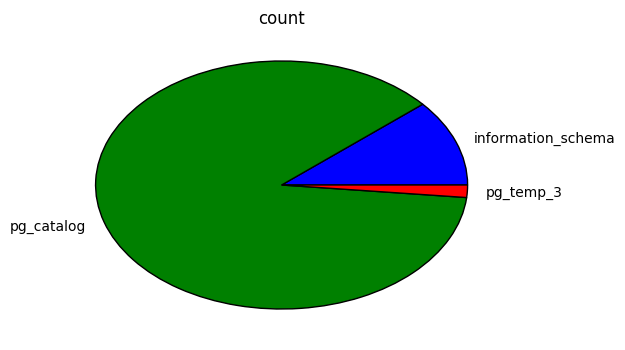

In [31]:
%matplotlib inline

r.pie()

`%sql` also makes it easy to create new tables (but `CREATE TABLE ... AS SELECT ...` would be far more efficmient)

In [32]:
%sql PERSIST df

u'Persisted df'

In [33]:
%sql SELECT * FROM df

3 rows affected.


index,schemaname,count
0,information_schema,7
1,pg_catalog,54
2,pg_temp_3,1


Note the difference from the original results...

In [34]:
r

schemaname,count
information_schema,7
pg_catalog,54
pg_temp_3,1


You can only persist a DataFrame though...

In [35]:
%sql PERSIST r

TypeError: r is not a Pandas DataFrame or Series

What do psycopg results look like?

In [36]:
c.execute('SELECT * FROM df')
c_df_result = c.fetchall()
c_df_result

[(0L, 'information_schema', 7L),
 (1L, 'pg_catalog', 54L),
 (2L, 'pg_temp_3', 1L)]

In [37]:
type(c_df_result)

list

In [38]:
type(c_df_result[0])

tuple

How do you know what's in the result?

In [39]:
c.description

(Column(name='index', type_code=20, display_size=None, internal_size=8, precision=None, scale=None, null_ok=None),
 Column(name='schemaname', type_code=25, display_size=None, internal_size=-1, precision=None, scale=None, null_ok=None),
 Column(name='count', type_code=20, display_size=None, internal_size=8, precision=None, scale=None, null_ok=None))

In [40]:
import psycopg2.extras

# Note this is a new cursor
c2 = db.cursor(cursor_factory=psycopg2.extras.DictCursor)
c2.execute('SELECT * FROM df')
c2_df_result = c2.fetchall()
c2_df_result

[[0L, 'information_schema', 7L],
 [1L, 'pg_catalog', 54L],
 [2L, 'pg_temp_3', 1L]]

In [41]:
c_df_result

[(0L, 'information_schema', 7L),
 (1L, 'pg_catalog', 54L),
 (2L, 'pg_temp_3', 1L)]

In [42]:
type(c2_df_result[0])

psycopg2.extras.DictRow

In [43]:
row = c2_df_result[0]

In [44]:
row

[0L, 'information_schema', 7L]

In [45]:
c_df_result[0]

(0L, 'information_schema', 7L)

Individual `DictRow` results behave like a combination list and dict.

In [46]:
row.keys()

['count', 'index', 'schemaname']

In [47]:
row[1]

'information_schema'

In [48]:
row['schemaname']

'information_schema'

In [49]:
row['schemaname'] is row[1]

True

Remember that results are static once they've been executed.

In [50]:
# Add 10 to each index
c2.execute('UPDATE df SET index=index*10')

In [51]:
c2_df_result

[[0L, 'information_schema', 7L],
 [1L, 'pg_catalog', 54L],
 [2L, 'pg_temp_3', 1L]]

In [52]:
c2.execute('SELECT * FROM df')

In [53]:
c2.fetchall()

[[0L, 'information_schema', 7L],
 [10L, 'pg_catalog', 54L],
 [20L, 'pg_temp_3', 1L]]

What if that's not what I wanted to do?

In [54]:
db.autocommit

False

In [55]:
db.rollback()
c.execute('UPDATE df SET index=index+10')
c2.execute('SELECT * FROM df') # different cursor! 
c2.fetchall()

[[10L, 'information_schema', 7L],
 [11L, 'pg_catalog', 54L],
 [12L, 'pg_temp_3', 1L]]

`%sql` can't see these updates yet though...

In [56]:
%sql SELECT * FROM df

3 rows affected.


index,schemaname,count
0,information_schema,7
1,pg_catalog,54
2,pg_temp_3,1


In [57]:
db2c = db2.cursor()
db2c.execute('SELECT * FROM df')
db2c.fetchall()

[(0L, 'information_schema', 7L),
 (1L, 'pg_catalog', 54L),
 (2L, 'pg_temp_3', 1L)]

In [58]:
c2.commit()

AttributeError: 'DictCursor' object has no attribute 'commit'

What if all you have is the cursor?

In [59]:
c2.connection.commit()
c2.connection is db

True

In [60]:
%sql SELECT * FROM df

3 rows affected.


index,schemaname,count
10,information_schema,7
11,pg_catalog,54
12,pg_temp_3,1


`c2_df_result` is unchanged though...

In [61]:
c2_df_result

[[0L, 'information_schema', 7L],
 [1L, 'pg_catalog', 54L],
 [2L, 'pg_temp_3', 1L]]

We can easily turn `psycopg` tuple results into a dataframe, but the dataframe won't have any names.

In [63]:
c.execute(SQLactivity)
c.fetchall()

[(88539,
  'decibel',
  'decibel',
  '',
  datetime.datetime(2017, 2, 15, 19, 25, 19, 787578, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-360, name=None)),
  'idle',
  'SELECT * FROM df'),
 (88581,
  'decibel',
  'decibel',
  'psycopg-1',
  datetime.datetime(2017, 2, 15, 19, 25, 57, 196871, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-360, name=None)),
  'active',
  'SELECT pid,datname,usename,application_name,state_change,state,query FROM pg_stat_activity'),
 (88582,
  'decibel',
  'decibel',
  'psycopg-2',
  datetime.datetime(2017, 2, 15, 19, 23, 15, 320824, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-360, name=None)),
  'idle in transaction',
  'SELECT * FROM df'),
 (89273,
  'decibel',
  'decibel',
  '',
  datetime.datetime(2017, 2, 15, 19, 13, 11, 132407, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-360, name=None)),
  'idle',
  'COMMIT')]

In [62]:
c.execute(SQLactivity)
pd.DataFrame(c.fetchall())

,0,1,2,3,4,5,6
0,88539,decibel,decibel,,2017-02-15 19:25:19.787578-06:00,idle,SELECT * FROM df
1,88581,decibel,decibel,psycopg-1,2017-02-15 19:25:57.196871-06:00,active,"SELECT pid,datname,usename,application_name,st..."
2,88582,decibel,decibel,psycopg-2,2017-02-15 19:23:15.320824-06:00,idle in transaction,SELECT * FROM df
3,89273,decibel,decibel,,2017-02-15 19:13:11.132407-06:00,idle,COMMIT


Why no names?

In [64]:
c.execute(SQLactivity)
type(c.fetchone())

tuple

Results from `c2` would have names associated with them!

In [65]:
c2.execute(SQLactivity)
pd.DataFrame([row for row in c2])

TypeError: Expected list, got DictRow

In [66]:
c2.execute(SQLactivity)
pd.DataFrame([dict(row) for row in c2])

,application_name,datname,pid,query,state,state_change,usename
0,,decibel,88539,SELECT * FROM df,idle,2017-02-15 19:25:19.787578-06:00,decibel
1,psycopg-1,decibel,88581,"SELECT pid,datname,usename,application_name,st...",active,2017-02-15 19:25:57.196871-06:00,decibel
2,psycopg-2,decibel,88582,SELECT * FROM df,idle in transaction,2017-02-15 19:23:15.320824-06:00,decibel
3,,decibel,89273,COMMIT,idle,2017-02-15 19:13:11.132407-06:00,decibel


Pandas can also execute SQL directly.

In [67]:
new_df=pd.read_sql(SQLactivity, db)
new_df

,pid,datname,usename,application_name,state_change,state,query
0,88539,decibel,decibel,,2017-02-16 01:25:19.787578+00:00,idle,SELECT * FROM df
1,88581,decibel,decibel,psycopg-1,2017-02-16 01:25:57.196871+00:00,active,"SELECT pid,datname,usename,application_name,st..."
2,88582,decibel,decibel,psycopg-2,2017-02-16 01:23:15.320824+00:00,idle in transaction,SELECT * FROM df
3,89273,decibel,decibel,,2017-02-16 01:13:11.132407+00:00,idle,COMMIT


Notice the ordering of the dataframe columns is different, because the ordering of keys in an ordinary `dict` is indeterminent.

In [68]:
# Lets create a new table...
c2.execute('CREATE TABLE df2(s serial, index int, schemaname name, count bigint)')

In [69]:
c2_df_result[0]

[0L, 'information_schema', 7L]

In [70]:
# And insert a row into it
SQLdf2_insert='''
INSERT INTO df2 VALUES(
    DEFAULT -- Use default value for s
    , %(index)s, %(schemaname)s, %(count)s -- We will provide these values *via psycopg2*
    )
'''

c2.execute(SQLdf2_insert, c2_df_result[0]) # c2_df_result[0] is the first row of the result set

In [71]:
%sql SELECT * FROM df2

(ProgrammingError) relation "df2" does not exist
LINE 1: SELECT * FROM df2
                      ^
 'SELECT * FROM df2' {}


In [72]:
db.commit()

In [73]:
%sql SELECT * FROM df2

1 rows affected.


s,index,schemaname,count
1,0,information_schema,7


`psycopg` supports multiple-execution.

In [74]:
c.executemany(SQLdf2_insert, c2_df_result) # Note executemany(), not just execute(), and no array index
pd.read_sql('SELECT * FROM df2', db)

,s,index,schemaname,count
0,1,0,information_schema,7
1,2,0,information_schema,7
2,3,1,pg_catalog,54
3,4,2,pg_temp_3,1


In [75]:
c.execute('SELECT * FROM df2')
c.fetchall()

[(1, 0, 'information_schema', 7L),
 (2, 0, 'information_schema', 7L),
 (3, 1, 'pg_catalog', 54L),
 (4, 2, 'pg_temp_3', 1L)]

In [76]:
c3=db.cursor(cursor_factory=psycopg2.extras.NamedTupleCursor)
c3.execute('SELECT * FROM df2')
r=c3.fetchall()
r

[Record(s=1, index=0, schemaname='information_schema', count=7L),
 Record(s=2, index=0, schemaname='information_schema', count=7L),
 Record(s=3, index=1, schemaname='pg_catalog', count=54L),
 Record(s=4, index=2, schemaname='pg_temp_3', count=1L)]

In [77]:
r[0]

Record(s=1, index=0, schemaname='information_schema', count=7L)

In [78]:
r[0][2]

'information_schema'

In [80]:
r[0].schemaname

'information_schema'

In [81]:
r[0][2] is r[0].schemaname

True

In [82]:
with db:
    c3.execute(SQLdf2_insert + ' RETURNING *', r[0]._asdict())
    r=c3.fetchall()

In [83]:
r

[Record(s=5, index=0, schemaname='information_schema', count=7L)]

In [84]:
%sql SELECT * FROM df2

5 rows affected.


s,index,schemaname,count
1,0,information_schema,7
2,0,information_schema,7
3,1,pg_catalog,54
4,2,pg_temp_3,1
5,0,information_schema,7


Why does that return everything? Because we used `db` as a context manager.

In [85]:
c.execute('BAD SQL')

ProgrammingError: syntax error at or near "BAD"
LINE 1: BAD SQL
        ^


In [107]:
c.execute('SELECT 1')

In [87]:
db.rollback() # A rollback on the connection puts us back in a clean state
c.execute('SELECT 1')
c.fetchall()

[(1,)]

What if we run bad SQL in a context manager?

In [88]:
with db:
    c.executemany(SQLdf2_insert, c2_df_result)
    c.execute('BAD SQL')
    c.execute('SELECT 1')
    c.fetchall()

ProgrammingError: syntax error at or near "BAD"
LINE 1: BAD SQL
        ^


Will this fail?

In [89]:
c.execute('SELECT 1')
c.fetchall()

[(1,)]

You can use cursors as context managers too.

In [90]:
with db.cursor() as new_c:
    new_c.execute('SELECT * FROM df2')
    r=new_c.fetchall()

In [91]:
r

[(1, 0, 'information_schema', 7L),
 (2, 0, 'information_schema', 7L),
 (3, 1, 'pg_catalog', 54L),
 (4, 2, 'pg_temp_3', 1L),
 (5, 0, 'information_schema', 7L)]

In [92]:
new_c.execute('SELECT 1')

InterfaceError: cursor already closed

In [93]:
new_c

<cursor object at 0x114e35a00; closed: -1>

In [94]:
c

<cursor object at 0x1142f7620; closed: 0>

In [95]:
new_c.closed

True

# Running python *inside* Postgres

In [96]:
%%sql
CREATE EXTENSION IF NOT EXISTS plpythonu;
CREATE FUNCTION add(
    v1 int
    , v2 int
) RETURNS text LANGUAGE plpythonu AS $$
return v1 + v2
$$;
SELECT add(1, 2);

Done.
Done.
1 rows affected.


add
3


In [97]:
%%sql
DO LANGUAGE plpythonu $$
plpy.execute('DROP FUNCTION add(int,int)')
$$;

Done.


[]

In [98]:
%sql SELECT add(1,1)

(ProgrammingError) function add(integer, integer) does not exist
LINE 1: SELECT add(1,1)
               ^
HINT:  No function matches the given name and argument types. You might need to add explicit type casts.
 'SELECT add(1,1)' {}


# Questions?
## Jim.Nasby@OpenSCG.com

#### This notebook can be downloaded from https://github.com/decibel/presentations/blob/master/Python%2BPostgres.ipynb

In [99]:
db.commit?

In [100]:
1+1

2

In [101]:
1+1

2